## FUNCTION
### Given Path and value name, we get the summary of all the stations

In [1]:
def read_ecad_sum(path, VAL):
    import pandas as pd
    import numpy as np
    ecad = pd.read_csv(path, names = ['STAID', 'SOUID', 'DATE', VAL, 'QUALITY'], skiprows = 21, parse_dates = ['DATE']).set_index('DATE')
    ecad = ecad[ecad['QUALITY'] == 0]
    output = pd.DataFrame()
    if ecad[VAL].count() >= 365 * 20 and ecad.index.max() >= pd.to_datetime('01/01/2000') and ecad.index.min() < pd.to_datetime('01/01/2000'):
        output['Monthly'] = ecad[VAL].resample(rule = 'M').sum()
        output['Month'] = output.index.month
        months = np.arange(12)
        for i in range(0, 12, 1):
            months[i] = output[output["Month"] == i + 1].mean().drop(['Month'])
        station = ecad['STAID'].mean()
        result = pd.DataFrame(data = months, index = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'], columns = [station]).T
    else:
        result = np.zeros(12)
        station = np.zeros(1)
    return result, station

def read_ecad_mean(path, VAL):
    import pandas as pd
    import numpy as np
    ecad = pd.read_csv(path, names = ['STAID', 'SOUID', 'DATE', VAL, 'QUALITY'], skiprows = 21, parse_dates = ['DATE']).set_index('DATE')
    ecad = ecad[ecad[VAL] != -9999]
    output = pd.DataFrame()
    if ecad[VAL].count() >= 365 * 20 and ecad.index.max() >= pd.to_datetime('01/01/2000') and ecad.index.min() < pd.to_datetime('01/01/2000'):
        output['Monthly'] = ecad[VAL].resample(rule = 'M').mean()
        output['Month'] = output.index.month
        months = np.arange(12)
        for i in range(0, 12, 1):
            months[i] = output[output["Month"] == i + 1].mean().drop(['Month'])
        station = ecad['STAID'].mean()
        result = pd.DataFrame(data = months, index = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'], columns = [station]).T
    else:
        result = np.zeros(12)
        station = np.zeros(1)
    return result, station

# Run of function

## Precipitation

In [2]:
import os
import pandas as pd
import numpy as np

entries = os.listdir(r'C:\Users\owner\Videos\ECA_blend_rr')

path = os.path.join(r"C:\Users\owner\Videos", "ECA_blend_rr")
path = path + "\\"

precipitation = np.zeros((len(entries), 12))
station = np.zeros((len(entries), 1))

for i in range(0, len(entries)):
    precipitation[i], station[i] = read_ecad_sum(path + entries[i], 'p')
    
prec = pd.DataFrame(data = precipitation, columns = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'], index = station.ravel())
prec.index.rename('Station ID', inplace = True)
prec['sum'] = prec.sum(axis = 1)
prec = prec[(prec.T != 0).any()]
prec

,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec,sum
Station ID,,,,,,,,,,,,,
1.0,436.0,336.0,332.0,348.0,433.0,558.0,698.0,738.0,595.0,576.0,537.0,502.0,6089.0
2.0,347.0,256.0,260.0,314.0,461.0,584.0,738.0,797.0,566.0,497.0,437.0,378.0,5635.0
3.0,281.0,204.0,225.0,234.0,332.0,540.0,785.0,742.0,494.0,415.0,345.0,310.0,4907.0
4.0,329.0,266.0,266.0,324.0,383.0,511.0,708.0,673.0,507.0,449.0,424.0,373.0,5213.0
5.0,314.0,260.0,259.0,321.0,385.0,515.0,698.0,671.0,510.0,448.0,415.0,362.0,5158.0
6.0,360.0,254.0,270.0,308.0,357.0,417.0,531.0,622.0,514.0,511.0,485.0,387.0,5016.0
7.0,409.0,304.0,309.0,401.0,397.0,520.0,594.0,773.0,642.0,660.0,698.0,493.0,6200.0
8.0,281.0,219.0,225.0,251.0,358.0,584.0,710.0,713.0,519.0,397.0,321.0,329.0,4907.0
9.0,273.0,213.0,218.0,248.0,355.0,583.0,699.0,713.0,513.0,390.0,313.0,318.0,4836.0


## Wind Speed

In [3]:
import os
import pandas as pd
import numpy as np

entries = os.listdir(r"C:\Dimos\database\ECA_blend_fg")

path = os.path.join(r"C:\Dimos\database", "ECA_blend_fg")
path = path + "\\"

ws = np.zeros((len(entries), 12))
station_ws = np.zeros((len(entries), 1))

for i in range(0, len(entries)):
    ws[i], station_ws[i] = read_ecad_mean(path + entries[i], 'U')

wind = pd.DataFrame(data = ws, columns = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'], index = station_ws.ravel())
wind.index.rename('Station ID', inplace = True)
wind['mean'] = wind.mean(axis = 1)
wind = wind[(wind.T != 0).any()]
wind

,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec,mean
Station ID,,,,,,,,,,,,,
5.0,41.0,40.0,40.0,38.0,36.0,36.0,34.0,33.0,38.0,38.0,38.0,40.0,37.666667
7.0,31.0,31.0,32.0,29.0,29.0,28.0,26.0,26.0,29.0,30.0,31.0,30.0,29.333333
32.0,15.0,15.0,15.0,15.0,13.0,13.0,13.0,12.0,12.0,13.0,13.0,16.0,13.750000
33.0,35.0,40.0,42.0,41.0,37.0,34.0,34.0,32.0,31.0,33.0,33.0,35.0,35.583333
34.0,20.0,21.0,22.0,24.0,22.0,21.0,21.0,18.0,16.0,17.0,18.0,20.0,20.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19687.0,28.0,27.0,27.0,25.0,24.0,23.0,19.0,17.0,19.0,23.0,24.0,26.0,23.500000
20045.0,53.0,50.0,52.0,43.0,41.0,38.0,34.0,33.0,45.0,46.0,51.0,51.0,44.750000
20046.0,56.0,53.0,52.0,48.0,48.0,49.0,47.0,47.0,53.0,56.0,57.0,56.0,51.833333


## Relative Humidity

In [4]:
import os
import pandas as pd
import numpy as np

entries = os.listdir(r"C:\Dimos\database\ECA_blend_hu")

path = os.path.join(r"C:\Dimos\database", "ECA_blend_hu")
path = path + "\\"

RelH = np.zeros((len(entries), 12))
station_RH = np.zeros((len(entries), 1))

for i in range(0, len(entries)):
    RelH[i], station_RH[i] = read_ecad_mean(path + entries[i], 'RH')

RH = pd.DataFrame(data = RelH, columns = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'], index = station_RH.ravel())
RH['mean'] = RH.mean(axis = 1)
RH = RH[(RH.T != 0).any()]
RH

,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec,mean
15.0,75.0,76.0,82.0,87.0,90.0,90.0,90.0,89.0,86.0,79.0,79.0,77.0,83.333333
16.0,78.0,74.0,69.0,63.0,65.0,65.0,64.0,67.0,72.0,77.0,80.0,81.0,71.250000
21.0,80.0,74.0,67.0,64.0,66.0,67.0,65.0,67.0,72.0,77.0,80.0,82.0,71.750000
22.0,67.0,65.0,59.0,49.0,45.0,40.0,36.0,36.0,41.0,50.0,58.0,65.0,50.916667
23.0,72.0,70.0,68.0,65.0,63.0,63.0,66.0,65.0,61.0,60.0,65.0,71.0,65.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19157.0,80.0,78.0,74.0,73.0,72.0,75.0,77.0,79.0,82.0,81.0,80.0,80.0,77.583333
19167.0,78.0,76.0,71.0,70.0,70.0,74.0,76.0,77.0,79.0,78.0,79.0,80.0,75.666667
19192.0,79.0,78.0,74.0,72.0,70.0,72.0,77.0,80.0,81.0,80.0,80.0,79.0,76.833333
20062.0,88.0,84.0,79.0,73.0,72.0,71.0,75.0,78.0,83.0,87.0,89.0,88.0,80.583333


## Radiation

In [5]:
import os
import pandas as pd
import numpy as np

entries = os.listdir(r"C:\Dimos\database\ECA_blend_qq")

path = os.path.join(r"C:\Dimos\database", "ECA_blend_qq")
path = path + "\\"

RS_ = np.zeros((len(entries), 12))
station_RS = np.zeros((len(entries), 1))

for i in range(0, len(entries)):
    RS_[i], station_RS[i] = read_ecad_mean(path + entries[i], 'RS')

RS = pd.DataFrame(data = RS_, columns = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'], index = station_RS.ravel())
RS.index.rename('Station ID', inplace = True)
RS['mean'] = RS.mean(axis = 1)
RS = RS[(RS.T != 0).any()]
RS

,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec,mean
Station ID,,,,,,,,,,,,,
12.0,45.0,77.0,123.0,167.0,210.0,224.0,222.0,193.0,142.0,92.0,50.0,37.0,131.833333
13.0,56.0,91.0,139.0,186.0,219.0,227.0,225.0,197.0,154.0,106.0,60.0,45.0,142.083333
14.0,43.0,72.0,114.0,162.0,199.0,206.0,209.0,182.0,134.0,88.0,46.0,34.0,124.083333
15.0,72.0,111.0,169.0,219.0,252.0,242.0,226.0,192.0,163.0,125.0,78.0,61.0,159.166667
16.0,36.0,66.0,114.0,172.0,224.0,236.0,235.0,203.0,144.0,84.0,40.0,28.0,131.833333
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18020.0,0.0,12.0,55.0,125.0,164.0,188.0,161.0,118.0,69.0,19.0,1.0,0.0,76.000000
18049.0,8.0,30.0,69.0,130.0,182.0,197.0,175.0,136.0,80.0,38.0,13.0,5.0,88.583333
18059.0,6.0,25.0,78.0,144.0,191.0,182.0,178.0,135.0,81.0,36.0,9.0,2.0,88.916667


## Mean temperature

In [6]:
import os
import pandas as pd
import numpy as np

entries = os.listdir(r"C:\Dimos\database\ECA_blend_tg")

path = os.path.join(r"C:\Dimos\database", "ECA_blend_tg")
path = path + "\\"

Tm = np.zeros((len(entries), 12))
station_T = np.zeros((len(entries), 1))

for i in range(0, len(entries)):
    Tm[i], station_T[i] = read_ecad_mean(path + entries[i], 'Tmean')
    
T = pd.DataFrame(data = Tm, columns = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'], index = station_T.ravel())
T.index.rename('Station ID', inplace = True)
T['mean'] = T.mean(axis = 1)
T = T[(T.T != 0).any()]
T

,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec,mean
Station ID,,,,,,,,,,,,,
1.0,-23.0,-23.0,1.0,48.0,105.0,145.0,163.0,151.0,113.0,67.0,24.0,-6.0,63.750000
2.0,-60.0,-55.0,-19.0,34.0,95.0,144.0,166.0,147.0,101.0,48.0,-2.0,-43.0,46.333333
3.0,-119.0,-110.0,-65.0,-4.0,57.0,113.0,139.0,117.0,68.0,9.0,-53.0,-101.0,4.250000
4.0,-23.0,-25.0,1.0,49.0,105.0,150.0,171.0,157.0,117.0,67.0,21.0,-9.0,65.083333
5.0,-24.0,-26.0,0.0,47.0,103.0,148.0,169.0,156.0,115.0,66.0,21.0,-10.0,63.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20824.0,-34.0,-28.0,3.0,50.0,102.0,149.0,161.0,146.0,118.0,74.0,21.0,-13.0,62.416667
20825.0,-37.0,-33.0,0.0,48.0,102.0,147.0,160.0,148.0,113.0,69.0,14.0,-21.0,59.166667
21766.0,-46.0,-46.0,-7.0,39.0,100.0,138.0,157.0,146.0,99.0,53.0,3.0,-35.0,50.083333


## Minimum temperature

In [7]:
import os
import pandas as pd
import numpy as np

entries = os.listdir(r"C:\Dimos\database\ECA_blend_tn")

path = os.path.join(r"C:\Dimos\database", "ECA_blend_tn")
path = path + "\\"

Tminimum = np.zeros((len(entries), 12))
station_Tmin = np.zeros((len(entries), 1))

for i in range(0, len(entries)):
    Tminimum[i], station_Tmin[i] = read_ecad_mean(path + entries[i], 'Tmin')
    
Tmin = pd.DataFrame(data = Tminimum, columns = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'], index = station_Tmin.ravel())
Tmin.index.rename('Station ID', inplace = True)
Tmin['mean'] = Tmin.mean(axis = 1)
Tmin = Tmin[(Tmin.T != 0).any()]
Tmin

,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec,mean
Station ID,,,,,,,,,,,,,
1.0,-51.0,-54.0,-34.0,3.0,49.0,89.0,112.0,106.0,73.0,36.0,0.0,-30.0,24.916667
2.0,-100.0,-98.0,-63.0,-15.0,37.0,85.0,111.0,98.0,58.0,14.0,-30.0,-74.0,1.916667
3.0,-167.0,-163.0,-123.0,-56.0,2.0,55.0,84.0,67.0,26.0,-23.0,-86.0,-140.0,-43.666667
4.0,-52.0,-56.0,-34.0,4.0,51.0,96.0,120.0,112.0,76.0,36.0,-2.0,-34.0,26.416667
5.0,-53.0,-57.0,-36.0,2.0,49.0,93.0,117.0,109.0,74.0,35.0,-3.0,-35.0,24.583333
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20320.0,-55.0,-53.0,-33.0,5.0,43.0,78.0,105.0,99.0,68.0,25.0,-13.0,-40.0,19.083333
20822.0,-49.0,-53.0,-22.0,16.0,66.0,105.0,126.0,119.0,84.0,44.0,2.0,-35.0,33.583333
20823.0,-56.0,-60.0,-28.0,10.0,61.0,101.0,120.0,111.0,78.0,38.0,-4.0,-44.0,27.250000


## Maximum temperature

In [8]:
import os
import pandas as pd
import numpy as np

entries = os.listdir(r"C:\Dimos\database\ECA_blend_tx")

path = os.path.join(r"C:\Dimos\database", "ECA_blend_tx")
path = path + "\\"

Tmaximum = np.zeros((len(entries), 12))
station_Tmax = np.zeros((len(entries), 1))

for i in range(0, len(entries)):
    Tmaximum[i], station_Tmax[i] = read_ecad_mean(path + entries[i], 'Tmax')
    
Tmax = pd.DataFrame(data = Tmaximum, columns = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'], index = station_Tmax.ravel())
Tmax.index.rename('Station ID', inplace = True)
Tmax['mean'] = Tmax.mean(axis = 1)
Tmax = Tmax[(Tmax.T != 0).any()]
Tmax

,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec,mean
Station ID,,,,,,,,,,,,,
1.0,0.0,6.0,39.0,96.0,159.0,198.0,214.0,200.0,157.0,100.0,46.0,14.0,102.416667
2.0,-26.0,-13.0,32.0,87.0,154.0,198.0,219.0,199.0,147.0,84.0,24.0,-10.0,91.250000
3.0,-78.0,-63.0,-13.0,39.0,103.0,159.0,186.0,161.0,107.0,39.0,-22.0,-59.0,46.583333
4.0,0.0,3.0,39.0,99.0,163.0,205.0,224.0,208.0,160.0,100.0,45.0,14.0,105.000000
5.0,0.0,1.0,38.0,97.0,161.0,204.0,223.0,207.0,159.0,99.0,45.0,14.0,104.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20320.0,0.0,5.0,35.0,80.0,128.0,161.0,186.0,178.0,137.0,83.0,37.0,13.0,86.916667
20822.0,3.0,6.0,46.0,97.0,158.0,199.0,215.0,203.0,161.0,104.0,51.0,18.0,105.083333
20823.0,0.0,4.0,46.0,97.0,157.0,198.0,214.0,202.0,160.0,102.0,48.0,14.0,103.500000


In [9]:
T.to_csv(r'C:\Users\owner\Google Drive 2\MSc\TU DELFT - Water Managment\Additional Thesis\T.txt', sep=';', index=True, header=True)
Tmax.to_csv(r'C:\Users\owner\Google Drive 2\MSc\TU DELFT - Water Managment\Additional Thesis\Tmax.txt', sep=';', index=True, header=True)
Tmin.to_csv(r'C:\Users\owner\Google Drive 2\MSc\TU DELFT - Water Managment\Additional Thesis\Tmin.txt', sep=';', index=True, header=True)
wind.to_csv(r'C:\Users\owner\Google Drive 2\MSc\TU DELFT - Water Managment\Additional Thesis\U.txt', sep=';', index=True, header=True)
RH.to_csv(r'C:\Users\owner\Google Drive 2\MSc\TU DELFT - Water Managment\Additional Thesis\RH.txt', sep=';', index=True, header=True)
RS.to_csv(r'C:\Users\owner\Google Drive 2\MSc\TU DELFT - Water Managment\Additional Thesis\QQ.txt', sep=';', index=True, header=True)

# Find mutual stations

In [10]:
hu = RH
qq = RS
tmeann = T
tmaxx = Tmax
tminn = Tmin
windspeed = wind

idx = qq.index.intersection(hu.index)
idx2  = windspeed.index.intersection(tmeann.index)
idx3 = tmaxx.index.intersection(tminn.index)
idx = pd.DataFrame(index = idx)
idx2  = pd.DataFrame(index = idx2)
idx3 = pd.DataFrame(index = idx3)
mutuals = idx.index.intersection(idx2.index)
mutuals = pd.DataFrame(index = mutuals)
mutuals = mutuals.index.intersection(idx3.index)
mutuals = pd.DataFrame(index = mutuals)
mutuals
# hu = pd.read_csv(r'C:\Dimos\database\whole data\RH.txt', skiprows = 18, names = ['STAID', 'Station Name', 'CN', 'Lat', 'Lon', 'h']).set_index('STAID')
# qq = pd.read_csv(r'C:\Dimos\database\whole data\RS.txt', skiprows = 18, names = ['STAID','Station Name', 'CN', 'Lat', 'Lon', 'h']).set_index('STAID')
tmeann = pd.read_csv(r'C:\Dimos\database\whole data\Tmean.txt', skiprows = 18, names = ['STAID','Station Name', 'CN', 'Lat', 'Lon', 'h']).set_index('STAID')
# tmaxx = pd.read_csv(r'C:\Dimos\database\whole data\Tmax.txt', skiprows = 18, names = ['STAID','Station Name', 'CN', 'Lat', 'Lon', 'h']).set_index('STAID')
# tminn = pd.read_csv(r'C:\Dimos\database\whole data\Tmin.txt', skiprows = 18, names = ['STAID','Station Name', 'CN', 'Lat', 'Lon', 'h']).set_index('STAID')
# windspeed = pd.read_csv(r'C:\Dimos\database\whole data\U.txt', skiprows = 18, names = ['STAID','Station Name', 'CN', 'Lat', 'Lon', 'h']).set_index('STAID')

stations_all = mutuals.merge(tmeann, left_index = True, right_index = True)
phi = np.zeros((len(stations_all['Lat']), 1))
for i in range(len(stations_all['Lat'])):
    phi[i] = (int(stations_all['Lat'].iloc[i][1:3]) + int(stations_all['Lat'].iloc[i][4:6])/60 + int(stations_all['Lat'].iloc[i][7:9])/3600)
stations_all['phi'] = phi * np.pi / 180
stations_all.to_csv(r'C:\Users\owner\Google Drive 2\MSc\TU DELFT - Water Managment\Additional Thesis\stations.txt', sep=';', index=True, header=True)
stations_all


,Station Name,CN,Lat,Lon,h,phi
32,BOURGES,FR,+47:03:33,+002:21:34,161,0.821337
34,BORDEAUX-MERIGNAC,FR,+44:49:50,-000:41:29,47,0.782441
36,PERPIGNAN,FR,+42:44:13,+002:52:22,42,0.745900
39,MARIGNANE,FR,+43:26:16,+005:12:57,9,0.758132
40,BAMBERG,DE,+49:52:31,+010:55:18,240,0.870488
...,...,...,...,...,...,...
18018,TJOTTA,NO,+65:49:45,+012:25:32,21,1.148936
18020,TROMSO - HOLT,NO,+69:39:14,+018:54:33,20,1.215690
18059,FROSTA,NO,+63:33:55,+010:41:35,32,1.109423
18811,TRONDHEIM - TYHOLT,NO,+63:25:21,+010:25:49,113,1.106931


In [39]:
def PM(m, Tmean, Tmax, Tmin, RH, U, RS, phi, h):
    import numpy as np
    julian = {'jan': 15, 'feb' : 45, 'mar' : 75, 'apr' : 105, 'may' : 135, 'jun': 165, 'jul' : 195, 'aug' : 225, 'sep' : 255, 'oct' : 285, 'nov': 315, 'dec': 345}    
    U2 = U * 0.1
    Tmean = Tmean * 0.1
    Tmin = Tmin * 0.1
    Tmax = Tmax * 0.1
    es1 = 0.6108 * np.exp((17.27 * Tmax)/(Tmax + 237.3))
    es2 = 0.6108 * np.exp((17.27 * Tmin)/(Tmin + 237.3))
    es = (es1 + es2) / 2
    ea = RH * es/100
    Delta = 4099 * (0.6108 * np.exp((17.27 * Tmean) / (Tmean + 237.3)) / ((Tmean + 237.3)**2))
    gamma = 0.665 * 0.001 * 1013 / 10
    dr = 1 + 0.033 * np.cos(2 * np.pi * julian[m] / 365)
    d = 0.4093* np.sin((2 * np.pi * julian[m] / 365) - 1.39)
    omega_s = np.arccos(-1 * np.tan(phi) * np.tan(d))
    Ra = (24 * 60 * 0.082 * dr / np.pi) * (omega_s * np.sin(phi) * np.sin(d) + np.cos(phi) * np.cos(d) * np.sin(omega_s))
    Rso = (0.75 + 2 * 0.00001 * h) * Ra
    Rs = 0.0864 * RS
    Rns = 0.77 * Rs
    Rnl = 4.903 * 0.000000001 * (((273.16 + Tmax)**4 + (273.16 + Tmin)**4) / 2) * (0.34 - 0.14 * np.sqrt(ea)) * (1.35 * (Rs/Rso) - 0.35)
    Rn = Rns - Rnl
    ETo = (0.408 * Delta * (Rn - 0)+(900 * gamma * U2 * (es - ea) / (273 + Tmean))) / (Delta + gamma * (1 + 0.34 * U2))
    return ETo

In [48]:
evap_jan, evap_feb, evap_mar, evap_apr, evap_may, evap_jun, evap_jul, evap_aug, evap_sep, evap_oct, evap_nov, evap_dec = ([] for i in range(12))
for i in stations_all.index:
    evap_jan.append(PM('jan', T.loc[i:i, 'jan'], Tmax.loc[i:i, 'jan'], Tmin.loc[i:i, 'jan'], RH.loc[i:i, 'jan'], wind.loc[i:i, 'jan'], RS.loc[i:i, 'jan'], stations_all.loc[i:i, 'phi'], stations_all.loc[i:i, 'h']).values)
    evap_feb.append(PM('feb', T.loc[i:i, 'feb'], Tmax.loc[i:i, 'feb'], Tmin.loc[i:i, 'feb'], RH.loc[i:i, 'feb'], wind.loc[i:i, 'feb'], RS.loc[i:i, 'feb'], stations_all.loc[i:i, 'phi'], stations_all.loc[i:i, 'h']).values)
    evap_mar.append(PM('mar', T.loc[i:i, 'mar'], Tmax.loc[i:i, 'mar'], Tmin.loc[i:i, 'mar'], RH.loc[i:i, 'mar'], wind.loc[i:i, 'mar'], RS.loc[i:i, 'mar'], stations_all.loc[i:i, 'phi'], stations_all.loc[i:i, 'h']).values)
    evap_apr.append(PM('apr', T.loc[i:i, 'apr'], Tmax.loc[i:i, 'apr'], Tmin.loc[i:i, 'apr'], RH.loc[i:i, 'apr'], wind.loc[i:i, 'apr'], RS.loc[i:i, 'apr'], stations_all.loc[i:i, 'phi'], stations_all.loc[i:i, 'h']).values)
    evap_may.append(PM('may', T.loc[i:i, 'may'], Tmax.loc[i:i, 'may'], Tmin.loc[i:i, 'may'], RH.loc[i:i, 'may'], wind.loc[i:i, 'may'], RS.loc[i:i, 'may'], stations_all.loc[i:i, 'phi'], stations_all.loc[i:i, 'h']).values)
    evap_jun.append(PM('jun', T.loc[i:i, 'jun'], Tmax.loc[i:i, 'jun'], Tmin.loc[i:i, 'jun'], RH.loc[i:i, 'jun'], wind.loc[i:i, 'jun'], RS.loc[i:i, 'jun'], stations_all.loc[i:i, 'phi'], stations_all.loc[i:i, 'h']).values)
    evap_jul.append(PM('jul', T.loc[i:i, 'jul'], Tmax.loc[i:i, 'jul'], Tmin.loc[i:i, 'jul'], RH.loc[i:i, 'jul'], wind.loc[i:i, 'jul'], RS.loc[i:i, 'jul'], stations_all.loc[i:i, 'phi'], stations_all.loc[i:i, 'h']).values)
    evap_aug.append(PM('aug', T.loc[i:i, 'aug'], Tmax.loc[i:i, 'aug'], Tmin.loc[i:i, 'aug'], RH.loc[i:i, 'aug'], wind.loc[i:i, 'aug'], RS.loc[i:i, 'aug'], stations_all.loc[i:i, 'phi'], stations_all.loc[i:i, 'h']).values)
    evap_sep.append(PM('sep', T.loc[i:i, 'sep'], Tmax.loc[i:i, 'sep'], Tmin.loc[i:i, 'sep'], RH.loc[i:i, 'sep'], wind.loc[i:i, 'sep'], RS.loc[i:i, 'sep'], stations_all.loc[i:i, 'phi'], stations_all.loc[i:i, 'h']).values)
    evap_oct.append(PM('oct', T.loc[i:i, 'oct'], Tmax.loc[i:i, 'oct'], Tmin.loc[i:i, 'oct'], RH.loc[i:i, 'oct'], wind.loc[i:i, 'oct'], RS.loc[i:i, 'oct'], stations_all.loc[i:i, 'phi'], stations_all.loc[i:i, 'h']).values)
    evap_nov.append(PM('nov', T.loc[i:i, 'nov'], Tmax.loc[i:i, 'nov'], Tmin.loc[i:i, 'nov'], RH.loc[i:i, 'nov'], wind.loc[i:i, 'nov'], RS.loc[i:i, 'nov'], stations_all.loc[i:i, 'phi'], stations_all.loc[i:i, 'h']).values)
    evap_dec.append(PM('dec', T.loc[i:i, 'dec'], Tmax.loc[i:i, 'dec'], Tmin.loc[i:i, 'dec'], RH.loc[i:i, 'dec'], wind.loc[i:i, 'dec'], RS.loc[i:i, 'dec'], stations_all.loc[i:i, 'phi'], stations_all.loc[i:i, 'h']).values)

C:\Users\owner\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [86]:
evap = pd.DataFrame(evap_jan, columns = ['Jan'], index = [stations_all.index])
evap['Feb'] = np.array(evap_feb).ravel()
evap['Mar'] = np.array(evap_mar).ravel()
evap['Apr'] = np.array(evap_apr).ravel()
evap['May'] = np.array(evap_may).ravel()
evap['Jun'] = np.array(evap_jun).ravel()
evap['Jul'] = np.array(evap_jul).ravel()
evap['Aug'] = np.array(evap_aug).ravel()
evap['Sep'] = np.array(evap_sep).ravel()
evap['Oct'] = np.array(evap_oct).ravel()
evap['Nov'] = np.array(evap_nov).ravel()
evap['Dec'] = np.array(evap_dec).ravel()
evap = evap[(evap >= 0).all(1)]
evap.to_csv(r'C:\Users\owner\Google Drive 2\MSc\TU DELFT - Water Managment\Additional Thesis\PM_ETo.txt', sep=';', index=True, header=True)
evap

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
32,0.400607,1.255171,5.413402,2.408616,3.224106,3.899814,4.275052,3.678844,2.893575,1.152420,0.527500,0.371748
34,0.531199,2.002140,5.094841,2.649615,3.446069,4.156225,4.500806,3.933497,3.161566,1.386620,0.673020,0.452939
36,1.189918,2.290419,4.130601,3.395295,4.158882,5.134794,5.860266,4.864159,3.622904,2.085892,1.369805,1.135838
39,0.899358,2.174700,4.629793,3.334521,4.455224,5.644312,6.341644,5.372458,3.926140,2.019011,1.144447,0.814449
40,0.382479,0.609647,1.216562,2.177121,3.139231,3.623539,3.691802,3.052841,1.894538,0.948344,0.487487,0.353736
...,...,...,...,...,...,...,...,...,...,...,...,...
17902,0.416797,0.794667,1.602904,2.559822,3.442722,4.134852,4.204538,3.564538,2.226045,1.231919,0.622768,0.380261
18017,0.424139,0.510569,0.985350,1.686301,2.623612,2.953587,2.940369,2.340558,1.461220,0.799831,0.515484,0.512792
18059,0.427579,0.544799,0.959846,1.674342,2.632764,2.879481,2.870035,2.277487,1.415301,0.815213,0.569230,0.490162
18811,0.411006,0.457344,0.859538,1.505735,2.431031,2.736458,2.655065,2.140496,1.240166,0.692743,0.526621,0.563589


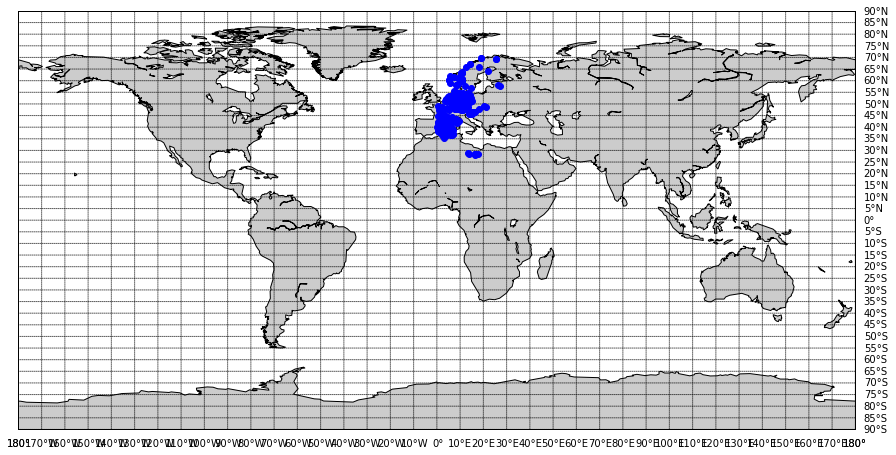

In [94]:
stations = pd.read_csv(r"C:\Users\owner\Google Drive 2\MSc\TU DELFT - Water Managment\Additional Thesis\stations.txt", delimiter = ';', index_col = 0)
phi = np.zeros(len(stations['Lat']))
labda = np.zeros(len(stations['Lat']))

for i in range(len(stations)):
    phi[i] = (int(stations['Lat'].iloc[i][1:3]) + int(stations['Lat'].iloc[i][4:6])/60 + int(stations['Lat'].iloc[i][7:9])/3600)
    labda[i] = (int(stations['Lon'].iloc[i][1:4]) + int(stations['Lon'].iloc[i][5:7])/60 + int(stations['Lon'].iloc[i][8:10])/3600)

import os
os.environ['PROJ_LIB'] = 'C:/Users/owner/Anaconda3/Lib/site-packages/mpl_toolkits/basemap'

from mpl_toolkits.basemap import Basemap
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize = (15, 15))
axs = plt.subplot(111)
# Always start witht the basemap function to initialize a map
m=Basemap()
 
# Then add element: draw coast line, map boundary, and fill continents:
m.drawcoastlines()
m.drawmapboundary()
m.fillcontinents()
parallels = np.arange(-90.,91.,5.)
m.drawparallels(parallels,labels=[False,True,True,False])
meridians = np.arange(-180.,181.,10.)
m.drawmeridians(meridians,labels=[True,False,False,True])
m.drawmapboundary(fill_color='white')
axs.plot(labda, phi, 'bo')
plt.plot();